In [1]:
import xarray as xr
import zarr
import glob
import pandas as pd
import numpy as np
import holoviews as hv
import hvplot.pandas
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import ipywidgets as widgets
from datetime import datetime, timedelta
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

Every year around February thousands of turtle hatchlings are born on the beaches of Northern KwaZulu-Natal. From here they enter the Indian Ocean and begin their journey south hitching a ride on the warm Agulhas Current. Little is known about the fate of these hatchlings save for the fact that only very few will make it to adulthood. One of the major obstacles these hatchlings face is being swept out of the warm agulhas current and into colder waters were they become hypothermic. Some of these hatchlings become stranded on beaches of the Western Cape where volunteers endevour to save them. The lucky few hatchlings which are found alive are brought to the Two Oceans Aquarium in Cape Town where they are rehabilitatad before they are strong enough to be released back into the wild. Monitoring such a vast coastline is however a mamoth task. Currently the program relies upon citizen reports from people happen across the stranded hatchlings, however recently the turtle team has had some succcess monitoring weather patterns and disspatching teams to turtle stranding hotspots when they think a stranding event may take place. At present this is however a very informal process and is believed could be improved upon by making better tools available to the turtle rescue teams. 

In [2]:
stranding_data = pd.read_csv('2015_2021_hatchling_stranding_summary.csv', names = ['Id', 'Date','Species','Location'])

In [3]:
display(stranding_data.Species.value_counts() )

Caretta caretta         622
Dermochelys coriacea      6
Name: Species, dtype: int64

I will only consider the Caretta Caretta species in a bid to reduce noise as this is by far the dominant species

In [4]:
stranding_data = stranding_data.loc[stranding_data['Species'] == 'Caretta caretta']

In [5]:
#correct a few spelling errors
stranding_data.loc[stranding_data['Location'] == 'Mosselbay', 'Location'] = 'Mossel Bay'
stranding_data.loc[stranding_data['Location'] == 'Witsand', 'Location'] = 'Witsands'
stranding_data.loc[stranding_data['Location'] == 'Tenikwa PLETT', 'Location'] = 'Plettenberg Bay'
stranding_data.loc[stranding_data['Location'] == 'Tenikwa', 'Location'] = 'Plettenberg Bay'

First lets consider the locations of the strandings 

In [6]:
display(stranding_data.Location.value_counts() )

Struisbaai             329
Mossel Bay              45
Muizenberg              38
Witsands                35
Plettenberg Bay         22
Arniston                22
Hermanus                18
Gaansbaai               12
Sedgefield              11
Strandfontein            8
Scarborough              8
Kommetjie                7
Fish Hoek                6
Knysna                   5
Stilbaai                 5
Plett                    4
Cape Agulhas             3
Stillbaai                3
Vleesbaai                3
Glencairn                3
Simons Town              2
Wilderness               2
Grotto Beach             2
Buffels Bay              2
Unknown                  1
Table Bay                1
Gordans Bay              1
Aghulas                  1
Milnerton                1
Blouberg                 1
Camps Bay                1
Blombos                  1
Smitswinkel              1
Kleinmond                1
Clovelly                 1
Sandy Bay                1
St Francis               1
K

Struisbaai is by far the most common stranding location presumably because of it's southerly geographic position, below the locations with more than 10 strandings recoded have been plotted

In [7]:
stranding_data = stranding_data.groupby('Location').filter(lambda x: len(x) >= 10) #consider only loactions with greater then 10 strandings

In [8]:
# Manually set locations for most common strandings
latlong_dict = {}
latlong_dict['Struisbaai'] = [-34.80, 20.10]
latlong_dict['Mossel Bay'] = [-34.15, 22.20]
latlong_dict['Muizenberg'] = [-34.11, 18.52]
latlong_dict['Witsands'] = [-34.41, 20.92]
latlong_dict['Arniston'] = [-34.67, 20.27]
latlong_dict['Plettenberg Bay'] = [-34.07, 23.44]
latlong_dict['Hermanus'] = [-34.44, 19.25]
latlong_dict['Sedgefield'] = [-34.10, 22.78]
latlong_dict['Gaansbaai'] = [-34.64, 19.35]

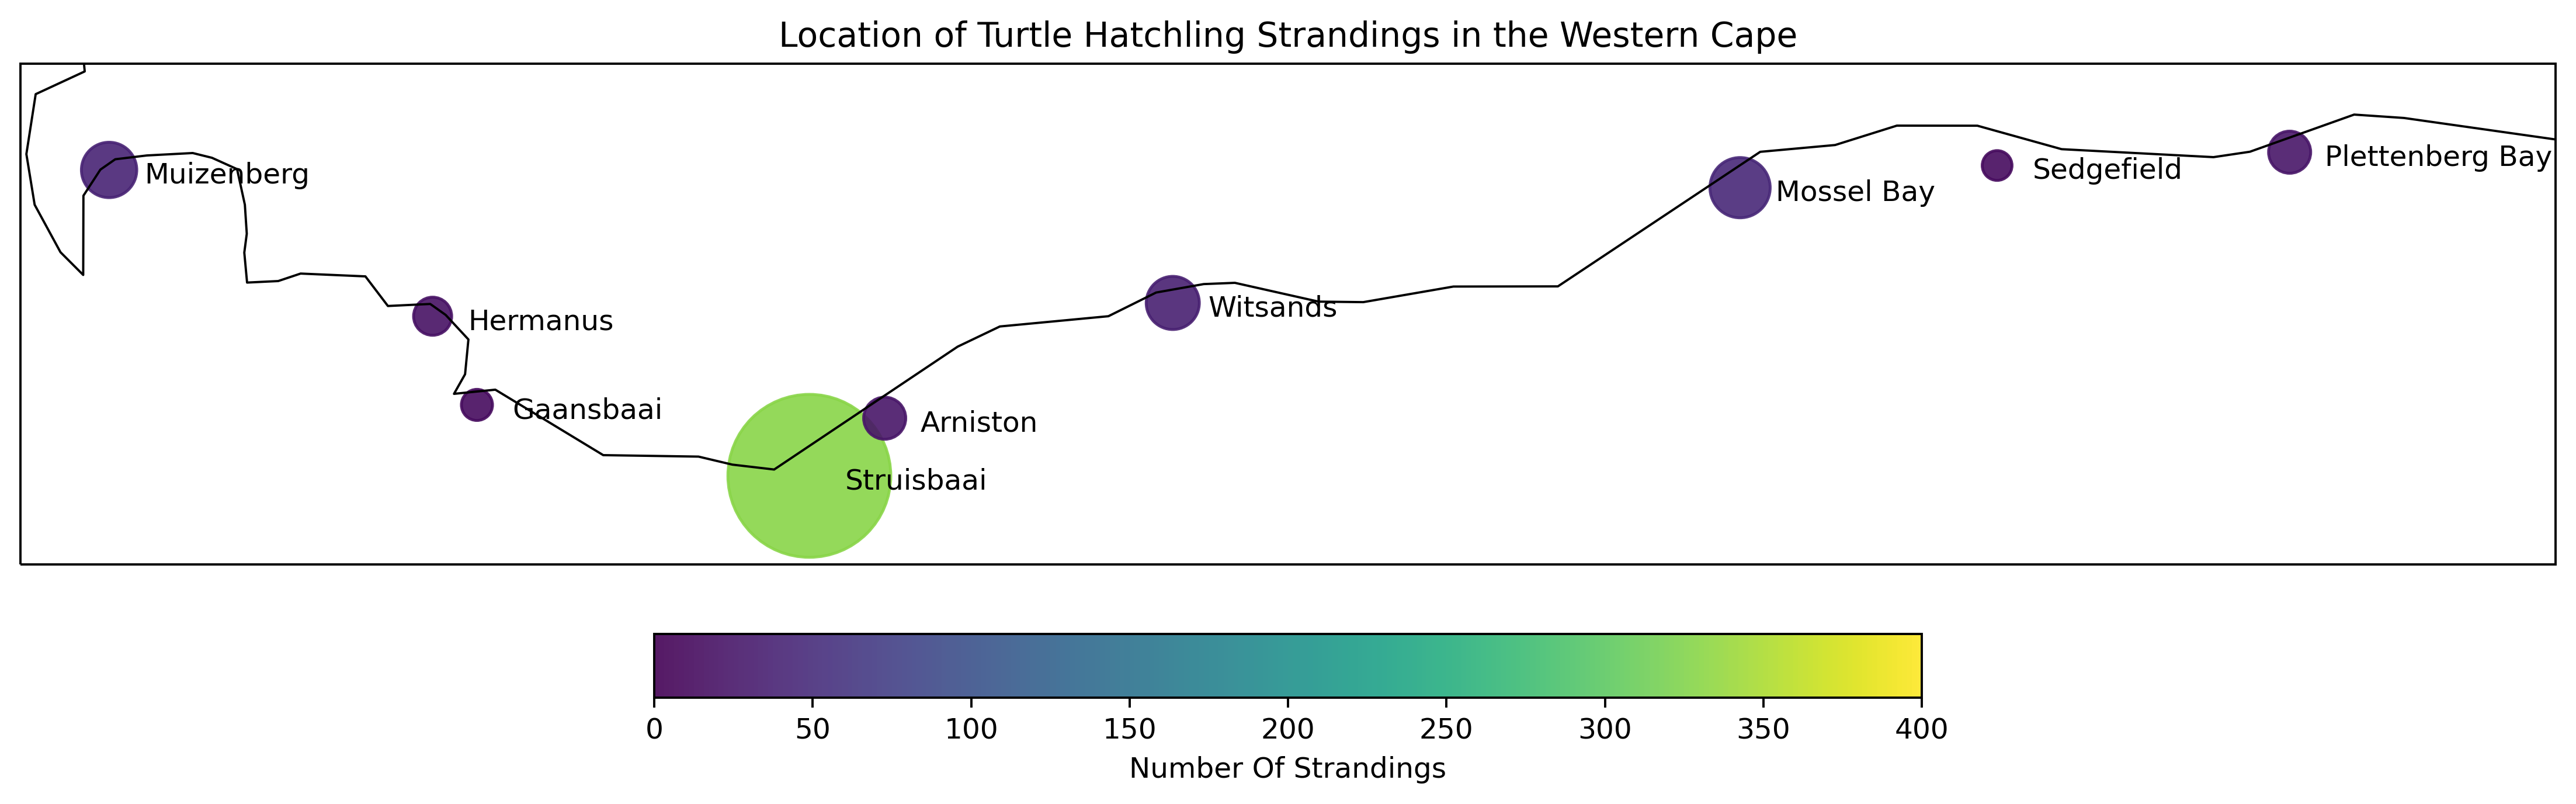

In [9]:
stranding_count = stranding_data.Location.value_counts() 

location = []
lats = []
lons = []
count = []
for index, n in stranding_count.items():
    location.append(index)
    lats.append(latlong_dict[index][0])
    lons.append(latlong_dict[index][1])
    count.append(n)


fig = plt.figure(figsize=(16,9), dpi = 350)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('50m', linewidth=0.8)

extent = (np.min(lons)-0.2,np.max(lons)+0.6, np.min(lats)-0.2,np.max(lats)+0.2)
ax.set_extent(extent)

scatterplot = ax.scatter(x = lons, y = lats, c=count, s = [x*10 for x in count], cmap = 'viridis', vmin = 0, vmax = 400, alpha=0.9,transform=ccrs.PlateCarree())

for loc,lat,lon in zip(location, lats, lons):
    ax.text(lon+0.08, lat-0.03, str(loc))

plt.colorbar(scatterplot, shrink = 0.5, orientation = 'horizontal', label = 'Number Of Strandings', pad=0.05)

plt.title('Location of Turtle Hatchling Strandings in the Western Cape')

plt.show()

In [10]:
extent

(18.32, 24.040000000000003, -35.0, -33.87)

Some years are seen to have vastly more strandings than other years, while strandings primarily occur in the months March, April and May

In [11]:
stranding_freq = stranding_data.groupby(stranding_data.Date).count()['Species'].rename('Standings')

stranding_freq.index = pd.to_datetime(stranding_freq.index, infer_datetime_format = True)

def make_plot(Frequency):
    if Frequency == 'Weekly':
        return stranding_freq.groupby(stranding_freq.index.week).sum().hvplot.bar().opts(title = 'Weekly Strandings')
    elif Frequency == 'Monthly':
        return stranding_freq.groupby(stranding_freq.index.month).sum().hvplot.bar().opts(title = 'Monthly Strandings', xlabel = 'Month')
    else:
        return stranding_freq.groupby(stranding_freq.index.year).sum().hvplot.bar().opts(title = 'Annual Strandings')
        
        
widgets.interact(make_plot, Frequency = ['Weekly','Monthly','Annual']);

interactive(children=(Dropdown(description='Frequency', options=('Weekly', 'Monthly', 'Annual'), value='Weekly…

This is true across all stations with more than 10 strandings recorded

In [12]:
def make_plot2(Location, Frequency):
    location_data = stranding_data.loc[stranding_data['Location'] == str(Location)]
    location_freq = location_data.groupby(location_data.Date).count()['Species'].rename('Standings')
    location_freq.index = pd.to_datetime(location_freq.index, infer_datetime_format=True)
    if Frequency == 'Weekly':
        return location_freq.groupby(location_freq.index.week).sum().reindex(np.linspace(1,52,52, dtype = int) , fill_value=0).hvplot.bar().opts(title = 'Weekly Strandings in '+str(Location))
    elif Frequency == 'Monthly':
        return location_freq.groupby(location_freq.index.month).sum().reindex(np.linspace(1,12,12, dtype = int) , fill_value=0).hvplot.bar().opts(title = 'Monthly Strandings in '+str(Location), xlabel = 'Month')
    elif Frequency == 'Daily':
        plt.scatter(x = location_freq.index, y = location_freq.values)
    else:
        return location_freq.groupby(location_freq.index.year).sum().hvplot.bar().opts(title = 'Annual Strandings in '+str(Location))
        
        
widgets.interact(make_plot2, Location=list(latlong_dict.keys()), Frequency = ['Weekly','Monthly','Annual','Daily']);

interactive(children=(Dropdown(description='Location', options=('Struisbaai', 'Mossel Bay', 'Muizenberg', 'Wit…

This is presumably due to the drift rate of the hatchling taking approximately 1 month to traverse the eastern coast of South Africa before arriving at the colder waters of the Western Cape, thus more hatchlings being situated off the coast and thus more likely for stranding events to occur

In [13]:
ds = xr.open_dataset('ERA5_reanalysis_East_Coast.nc').load()

In [14]:
# ensure lat lon corresponds to a point where sst is available
ocean_lons = ds.sst[0].dropna(dim = 'lat', how = 'any').dropna(dim = 'lon', how = 'any').lon.values
ocean_lats = ds.sst[0].dropna(dim = 'lat', how = 'any').dropna(dim = 'lon', how = 'any').lat.values

def return_nearest_ocean_latlon(latlon):
    ocean_lat = min(ocean_lats, key=lambda x:abs(x-latlon[0]))
    ocean_lon = min(ocean_lons, key=lambda x:abs(x-latlon[1]))
    return [ocean_lat,ocean_lon]


ocean_latlong_dict = {}
for index in latlong_dict:
    ocean_latlong_dict[index] = return_nearest_ocean_latlon(latlong_dict[index])

In [15]:
location = 'Struisbaai'

ds_loc = ds
ds_loc = ds_loc.sel(lat = ocean_latlong_dict[str(location)][0], method = 'nearest').sel(lon = ocean_latlong_dict[str(location)][1], method = 'nearest')


location_data = stranding_data.loc[stranding_data['Location'] == str(location)]
location_freq = location_data.groupby(location_data.Date).count()['Species'].rename('Standings')
location_freq.index = pd.to_datetime(location_freq.index, infer_datetime_format=True)

dates_sorted = list(location_freq.sort_values(ascending=False).index)

In [16]:
ocean_latlong_dict[str(location)]

[-35.0, 20.0]

In [17]:
dates_sorted[0]

Timestamp('2015-04-10 00:00:00')

In [18]:
location_freq[dates_sorted[10]]

4

In [19]:
def wind_plot(stranding_date):
    date = stranding_date
    date_7 = date + timedelta(days = -7)
    d = ds_loc.sel(time = slice(str(date_7), str(date)))
    x = list(range(len(d.time.values)))
    x.reverse()
    x = [round(x_,2) for x_ in x]
    ws = list(zip(x, d.ws.values))
    ws_dir = list(zip(x, d.ws.values+3, [np.deg2rad(((dir_ - 90) % 360)) for dir_ in d.dir.values], d.ws.values))
    return hv.Overlay([hv.Curve(ws), hv.VectorField(ws_dir)]).opts(
        height=600, 
        width=900,
        xlabel='Hours Before Stranding', 
        ylabel='Wind Speed (knots)', 
        title='Wind Speed and Direction Over Previous 7 Days, since '+ str(location_freq[date])+' Turtles stranded in Struisbaai',
        invert_xaxis = True,
        xticks=[(0, '0'), (24, '1'), (48, '2'), (72, '3'), (96, '4'), (120, '5'), (148, '6'), (172, '7')]
    )

def var_plot(variable, stranding_date):
    date = stranding_date
    date_7 = date + timedelta(days = -7)
    d = ds_loc.sel(time = slice(str(date_7), str(date)))
    x = list(range(len(d.time.values)))
    x.reverse()
    x = [round(x_,2) for x_ in x]
    if variable == 'Sea Surface Temperature':
        var = list(zip(x, d.sst.values))
    else:
        var = list(zip(x, d.t2m.values))
    return hv.Curve(var).opts(
        height=600, 
        width=900,
        xlabel='Hours Before Stranding', 
        ylabel='Temperature', 
        title='Temperature Over Previous 7 Days, since '+ str(location_freq[date])+' Turtles stranded in Struisbaai',
        invert_xaxis = True,
        xticks=[(0, '0'), (24, '1'), (48, '2'), (72, '3'), (96, '4'), (120, '5'), (148, '6'), (172, '7')]
    )

def time_series_plot(variable, stranding_date):
    if variable == 'Wind':
        return wind_plot(stranding_date)
    else:
        return var_plot(variable, stranding_date)

widgets.interact(time_series_plot, variable = ['Wind', 'Sea Surface Temperature','Air Temperature'], stranding_date=dates_sorted);

interactive(children=(Dropdown(description='variable', options=('Wind', 'Sea Surface Temperature', 'Air Temper…

In [20]:
ds_loc_daily = ds_loc.resample(time = 'D', closed = "right").mean().load()
ds_seasonal = ds_loc_daily.where(ds_loc.time.dt.season == 'MAM').dropna(dim='time', how = 'all')

strandings = list(set(stranding_data.loc[stranding_data['Location'] == 'Struisbaai'].Date))
strandings = pd.to_datetime(strandings)

march = [x for x in strandings if x.month == 3]
april = [x for x in strandings if x.month == 4]
may = [x for x in strandings if x.month == 5]
dates = march + april + may
dates.sort()

In [21]:
lagged = {}
for lag in [0, -1,-3,-7]:
    dates_1 = [date + timedelta(days = lag) for date in dates]
    lagged[lag] = ds_loc_daily.sel(time = dates_1)

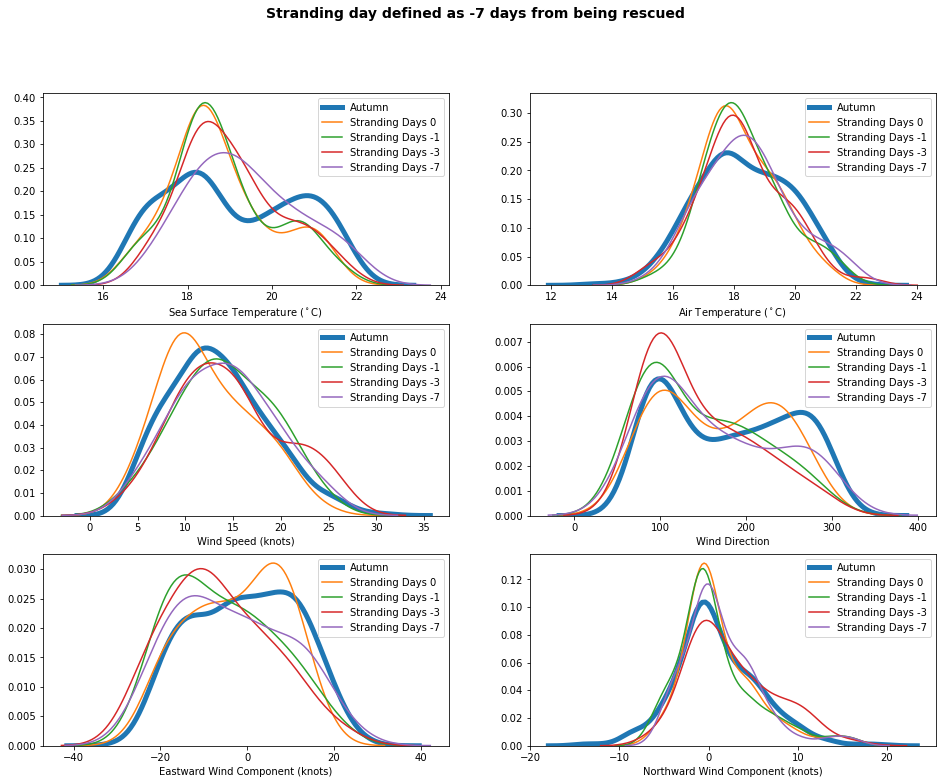

In [22]:
def make_plot():
    fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(16,12))
    axs=axs.flatten()
    for i,var in enumerate(['sst','t2m','ws','dir','u10','v10']):
        sns.kdeplot(ds_seasonal[str(var)].values, ax = axs[i], label = 'Autumn', lw= 5)
        for key in lagged:
            sns.kdeplot(lagged[key][str(var)].values, ax = axs[i],  label = 'Stranding Days '+str(key))
        #axs[i].set_title(str(var))
    axs[0].legend()
    axs[0].set_xlabel('Sea Surface Temperature ($^\circ$C)')
    axs[1].set_xlabel('Air Temperature ($^\circ$C)')
    axs[2].set_xlabel('Wind Speed (knots)')
    axs[3].set_xlabel('Wind Direction')
    axs[4].set_xlabel('Eastward Wind Component (knots)')
    axs[5].set_xlabel('Northward Wind Component (knots)')
    fig.suptitle('Stranding day defined as '+str(lag)+' days from being rescued', fontsize=14, fontweight='bold')


        
make_plot()

In [23]:
df = ds_loc_daily.to_dataframe()

In [24]:
x = ds_loc_daily
x = x[['u10','v10']].rolling(time = 5).mean(dim = 'time')
df['u10_7'] = x.u10
df['v10_7'] = x.v10

In [25]:
x = ds_loc_daily.sst
sst_delta = (x.values[7:] - x.values[:-7])
df['sst_delta'] = np.concatenate([np.zeros(7), sst_delta])

In [26]:
df = df.fillna(0)

In [27]:
location = 'Struisbaai'

location_data = stranding_data.loc[stranding_data['Location'] == str(location)]
location_freq = location_data.groupby(location_data.Date).count()['Species'].rename('Standings')
location_freq.index = pd.to_datetime(location_freq.index)
df['strandings'] = location_freq.reindex(df.index).fillna(0)

In [28]:
df['month'] = df.index.month

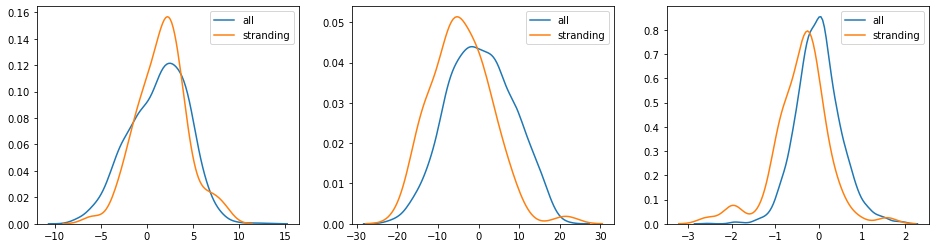

In [29]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(16,4))
axs=axs.flatten()
for i,var in enumerate(['v10_7', 'u10_7', 'sst_delta']):
    sns.kdeplot(df[var], label = 'all', ax = axs[i],)
    sns.kdeplot(df[var].where(df.strandings >= 1), label = 'stranding', ax = axs[i],)
axs[0].legend()
plt.show()


In [30]:
from sklearn.ensemble import RandomForestRegressor

In [31]:
train = df.iloc[:2045]
test = df.iloc[2045:]

In [32]:
sel_var = ['month', 'ws','dir', 'u10_7','sst_delta']

In [33]:
train_features = np.array(train[sel_var])
train_labels = np.array(train['strandings'])
test_features = np.array(test[sel_var])
test_labels = np.array(test['strandings'])

In [34]:
# Instantiate model
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(random_state=42)

In [35]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
#Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 5), 'degrees.')

Mean Absolute Error: 0.236 degrees.


In [36]:
out = pd.DataFrame({'day': test.index, 'predictions' : list(predictions), "test_labels": list(test_labels)}).set_index('day')
pred_ = list(zip(out.index, out.predictions.where(out.predictions>=1)))
maybe_ = list(zip(out.index, out.predictions.where(out.predictions>0.5).where(out.predictions<1)))
test_ = list(zip(out.index, out.test_labels.where(out.test_labels>=1)))

In [37]:
hv.Overlay([hv.Scatter(test_).opts(size = 10).relabel('Observed'), hv.Scatter(pred_).opts(size = 7).relabel('Predicted'), hv.Scatter(maybe_).opts(size = 7).relabel('maybe')]).opts(
        height=600, 
        width=900,
        xlabel='Date', 
        ylabel='Strandings', 
        title='Stranding Prediction',
        show_legend = True
    )

:Overlay
   .Scatter.Observed  :Scatter   [x]   (y)
   .Scatter.Predicted :Scatter   [x]   (y)
   .Scatter.Maybe     :Scatter   [x]   (y)

In [ ]:
from ecmwf.opendata import Client
import ecmwf.data as ecdata
from magpye import GeoMap
from ecmwf.opendata import Client

In [ ]:
client = Client("ecmwf", beta=True)

In [ ]:
parameters = ['10u','10v'] #,'sst' is not available!!!

In [ ]:
for i in np.arange(0,246,6): #5 day forecast 6 hour steps
    filename = 'ECMWF_operational/10m_U_V_step_'+f"{i:03}"+'.grib'
    client.retrieve(
     date=0,
     time=0,
     step=[i],
     stream="enfo",
     type=['cf'],
     levtype="sfc",
     param=parameters,
     target=filename
    )

In [ ]:
files = glob.glob('ECMWF_operational/10m_U_V_step_*.grib')
files.sort()

In [ ]:
data = []
for file in files:
    data.append(xr.open_mfdataset(file, engine = 'cfgrib'))

In [ ]:
ds_forecast = xr.concat(data, dim = 'valid_time').chunk({'valid_time':9, 'latitude':451, 'longitude':900})

In [ ]:
x = ds_forecast.sel(latitude = ocean_latlong_dict[str(location)][0], method = 'nearest').sel(longitude = ocean_latlong_dict[str(location)][1], method = 'nearest')

def wind_speed(U, V):
    func = lambda x, y: np.sqrt(x**2 + y**2)
    return xr.apply_ufunc(func, U, V, dask = 'parallelized')

def wind_dir(U, V):
    func = lambda x, y: np.mod(180+np.rad2deg(np.arctan2(x, y)),360)
    return xr.apply_ufunc(func, U, V, dask = 'parallelized')

x['ws'] = wind_speed(x.u10, x.v10)
x['dir'] = wind_dir(x.u10, x.v10)

df_forecast = x.to_dataframe()

x = x[['u10','v10']].rolling(valid_time = 5).mean(dim = 'valid_time')
df_forecast['u10_7'] = x.u10
df_forecast['v10_7'] = x.v10

#sst_delta = (x.sst.values[5:] - x.sst.values[:-5])
#df_forecast['sst_delta'] = np.concatenate([np.zeros(5), sst_delta])

In [ ]:
df_forecast